<a href="https://colab.research.google.com/github/shu-bee/Pytorch_tutorial/blob/main/What%20is%20torch.nn%20really%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is torch.nn really?

PyTorch provides the elegantly designed modules and classes torch.nn , torch.optim , Dataset , and DataLoader to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they’re doing. 

MNIST data setup

In [2]:
from pathlib import Path
import requests
DATA_PATH=Path("data")
PATH=DATA_PATH/"mnist"
PATH.mkdir(parents=True,exist_ok=True)
URL="https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME="mnist.pkl.gz"

if not (PATH/FILENAME).exists():
  content=requests.get(URL+FILENAME).content
  (PATH/FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length 784 (=28x28). Let’s take a look at one; we need to reshape it to 2d first.

(50000, 784)
<class 'numpy.ndarray'>


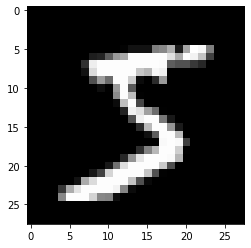

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(type(x_train))

Pytorch uses torch.tensor, so we need to convert our data

In [5]:
import torch
print(type(x_train))
#conver numpy to torch.tensor
#map関数で全てのnumpy arraysに対してtorch.tensorへ変換を行う
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)    
)
n, c =x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(type(x_train))
print(x_train.shape)
print(y_train.min(), y_train.max())

<class 'numpy.ndarray'>
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
<class 'torch.Tensor'>
torch.Size([50000, 784])
tensor(0) tensor(9)


Neural net from scratch(no torch.nn)

PyTorch provides methods to create random or zero-filled tensors, which we will use to create our weights and bias for a simple linear model. These are just regular tensors, with one very special addition: we tell PyTorch that they require a gradient. This causes PyTorch to record all of the operations done on the tensor, so that it can calculate the gradient during back-propagation automatically!

For the weights, we set requires_grad after the initialization, since we don’t want that step included in the gradient. (Note that a trailling _ in PyTorch signifies that the operation is performed in-place.)

In [6]:
import math

weights=torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10,requires_grad=True)


Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we’ll write log_softmax and use it. Remember: although PyTorch provides lots of pre-written loss functions, activation functions, and so forth, you can easily write your own using plain python. PyTorch will even create fast GPU or vectorized CPU code for your function automatically.

In [7]:
a = [[1, 0], [0, 1]]
b = [[4, 1], [2, 2]]
print(np.dot(a, b))
print(np.array(a)@np.array(b))

[[4 1]
 [2 2]]
[[4 1]
 [2 2]]


In [8]:
def log_softmax(x):
  return x-x.exp().sum(-1).log().unsqueeze(-1)

#activation function
def model(xb):
  return log_softmax(xb @ weights+bias)

In the above, the @ stands for the dot(=行列積) product operation. 

https://numpy.org/doc/stable/reference/generated/numpy.dot.html?highlight=dot#numpy.dot

We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won’t be any better than random at this stage, since we start with random weights.

In [9]:
bs=64
xb = x_train[0:bs]
preds=model(xb)     # a mini-batch from
preds[0], preds.shape#predictions
print(preds[0],preds.shape)

tensor([-2.8124, -2.2856, -2.2421, -1.4903, -2.9896, -2.5176, -2.3334, -2.1105,
        -2.5510, -2.5307], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the preds tensor contains not only the tensor values, but also a gradient function. We’ll use this later to do backprop.

Let’s implement negative log-likelihood(=負の対数尤度) to use as the loss function (again, we can just use standard Python):

In [10]:
def nll(input, target):
  return -input[range(target.shape[0]),target].mean()

loss_func=nll
a = np.array([[4, 1],[2, 1],[2, 2]])
b = np.array([1, 0, 1])
print(loss_func(a,b))

-1.6666666666666667


Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.

In [11]:
yb = y_train[0:bs]
print(yb.shape[0])
print(preds.shape)
print(loss_func(preds, yb))

64
torch.Size([64, 10])
tensor(2.3378, grad_fn=<NegBackward>)


Let’s also implement a function to calculate the accuracy of our model. For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

Let’s check the accuracy of our random model, so we can see if our accuracy improves as our loss improves.

In [12]:
def accuracy(out,yb):
  preds=torch.argmax(out,dim=1)
  print("preds",preds,preds.shape)
  print("yb",yb,yb.shape)
  return (preds==yb).float().mean()

print(accuracy(preds,yb))


preds tensor([3, 3, 2, 3, 1, 7, 3, 3, 1, 7, 3, 7, 2, 3, 1, 1, 1, 1, 3, 1, 7, 3, 1, 3,
        1, 7, 1, 3, 1, 1, 9, 7, 3, 3, 3, 7, 3, 3, 9, 3, 1, 1, 1, 1, 2, 1, 1, 1,
        3, 3, 3, 3, 2, 3, 7, 1, 1, 1, 1, 3, 7, 3, 3, 2]) torch.Size([64])
yb tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0]) torch.Size([64])
tensor(0.1406)


We can now run a training loop. For each iteration, we will:

・select a mini-batch of data (of size bs)

・use the model to make predictions

・calculate the loss

・loss.backward() updates the gradients of the model, in this case, 

・weights and bias

We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch’s Autograd records operations here.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

In [13]:
from IPython.core.debugger import set_trace
lr=0.5
epochs=2


for epoch in range(epochs):
  for i in range((n-1)//bs+1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print(x_train.shape,xb.shape)
print(pred.shape)
print(yb.shape)

torch.Size([50000, 784]) torch.Size([16, 784])
torch.Size([16, 10])
torch.Size([16])


That’s it: we’ve created and trained a minimal neural network (in this case, a logistic regression, since we have no hidden layers) entirely from scratch!

Let’s check the loss and accuracy and compare those to what we got earlier. We expect that the loss will have decreased and accuracy to have increased, and they have.

In [14]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NegBackward>)
preds tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]) torch.Size([16])
yb tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]) torch.Size([16])
tensor(1.)


Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only we’ll start taking advantage of PyTorch’s nn classes to make it more concise and flexible. At each step from here, we should be making our code one or more of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from torch.nn.functional (which is generally imported into the namespace F by convention). This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

If you’re using negative log likelihood loss and log softmax activation, then Pytorch provides a single function F.cross_entropy that combines the two. So we can even remove the activation function from our model.

In [15]:
import torch.nn.functional as F

loss_func = F.cross_entropy
#=>RELUなど他の活性化関数を使いたい時は？
#def log_softmax(x):
#    return x - x.exp().sum(-1).log().unsqueeze(-1)
#def model(xb):
#    return log_softmax(xb @ weights + bias)

def model(xb):
    return xb @ weights + bias

Note that we no longer call log_softmax in the model function. Let’s confirm that our loss and accuracy are the same as before:

In [16]:
print(loss_func(model(xb), yb))
print(accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward>)
preds tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]) torch.Size([16])
yb tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8]) torch.Size([16])
tensor(1.)


Refactor using nn.Module

Next up, we’ll use nn.Module and nn.Parameter, for a clearer and more concise training loop. We subclass nn.Module (which itself is a class and able to keep track of state). In this case, we want to create a class that holds our weights, bias, and method for the forward step. nn.Module has a number of attributes and methods (such as .parameters() and .zero_grad()) which we will be using.

nn.Module (uppercase M) is a PyTorch specific concept, and is a class we’ll be using a lot. nn.Module is not to be confused with the Python concept of a (lowercase m) module, which is a file of Python code that can be imported.

In [17]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Since we’re now using an object instead of just using a function, we first have to instantiate our model:

In [18]:
model =Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that nn.Module objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [19]:
pred=model(xb)
print(pred.shape,yb.shape)
print(loss_func(model(xb), yb))

torch.Size([16, 10]) torch.Size([16])
tensor(2.3508, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter by name, and manually zero out the grads for each parameter separately, like this:

In [20]:
#with torch.no_grad():
#    weights -= weights.grad * lr
#    bias -= bias.grad * lr
#    weights.grad.zero_()
#    bias.grad.zero_()

Now we can take advantage of model.parameters() and model.zero_grad() (which are both defined by PyTorch for nn.Module) to make those steps more concise and less prone to the error of forgetting some of our parameters, particularly if we had a more complicated model:

In [21]:
#with torch.no_grad():
#    for p in model.parameters(): p -= p.grad * lr
#    model.zero_grad()

We’ll wrap our little training loop in a fit function so we can run it again later.

In [22]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let’s double-check that our loss has gone down:

In [23]:
print(loss_func(model(xb), yb))

tensor(0.0818, grad_fn=<NllLossBackward>)


Refactor using nn.Linear

We continue to refactor our code. Instead of manually defining and initializing self.weights and self.bias, and calculating xb  @ self.weights + self.bias, we will instead use the Pytorch class nn.Linear for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [24]:
#class Mnist_Logistic(nn.Module):
#    def __init__(self):
#        super().__init__()
#        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
#        self.bias = nn.Parameter(torch.zeros(10))
#    def forward(self, xb):
#        return xb @ self.weights + self.bias

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:

In [25]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3160, grad_fn=<NllLossBackward>)


We are still able to use our same fit method as before.

In [26]:
fit()
print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>)


Refactor using optim

Pytorch also has a package with various optimization algorithms, torch.optim. We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

This will let us replace our previous manually coded optimization step

In [27]:
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

and instead use just:

In [28]:
#opt.step()
#opt.zero_grad()

(optim.zero_grad() resets the gradient to 0 and we need to call it before computing the gradient for the next minibatch.)

In [29]:
from torch import optim

We’ll define a little function to create our model and optimizer so we can reuse it in the future.

In [30]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3495, grad_fn=<NllLossBackward>)
tensor(0.0815, grad_fn=<NllLossBackward>)


Refactor using Dataset

PyTorch has an abstract Dataset class. A Dataset can be anything that has a __len__ function (called by Python’s standard len function) and a __getitem__ function as a way of indexing into it. This tutorial walks through a nice example of creating a custom FacialLandmarkDataset class as a subclass of Dataset.

PyTorch’s TensorDataset is a Dataset wrapping tensors. 
By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. 

（日本語訳注：DatasetがTensorの最初の次元をもとにデータの操作を行うのは、最初の次元が個々のデータのインデックス（何番目のデータなのか）を表しているためです。例えば、MNISTデータセットの場合は、一時限目がデータのインデックス、2次元目がx座標、3次元目がy座標になります）

This will make it easier to access both the independent and dependent variables in the same line as we train.

（日本語訳注：この例において独立変数とはモデルに入力する画像データxであり、従属変数はその画像に対応するラベルyのことを指します）

In [31]:
from torch.utils.data import TensorDataset

Both x_train and y_train can be combined in a single TensorDataset, which will be easier to iterate over and slice.

In [32]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:

In [33]:
#xb = x_train[start_i:end_i]
#yb = y_train[start_i:end_i]

Now, we can do these two steps together:

In [34]:
#xb,yb = train_ds[i*bs : i*bs+bs]

In [35]:
model,opt=get_model()

for epoch in range(epochs):
  for i in range((n-1)//bs+1):
    xb,yb=train_ds[i*bs:i*bs+bs]
    pred=model(xb)
    loss=loss_func(pred,yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(0.0831, grad_fn=<NllLossBackward>)



Refactor using DataLoader

Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches. Rather than having to use train_ds[i*bs : i*bs+bs], the DataLoader gives us each minibatch automatically.

In [36]:
from torch.utils.data import DataLoader

train_ds=TensorDataset(x_train,y_train)
train_dl=DataLoader(train_ds,batch_size=bs)

previously, our loop iterated over batches (xb,yb) like this:

In [37]:
#for i in range((n-1)//bs + 1):
#    xb,yb = train_ds[i*bs : i*bs+bs]
#    pred = model(xb)

Now, our loop is much cleaner, as (xb,yb) are loaded automatically from the data loader:

In [38]:
#or xb,yb in train_dl:
#  pred=model(xb)

In [39]:
model,opt=get_model()

for epoch in range(epochs):
  for xb, yb in train_dl:
    pred=model(xb)
    loss=loss_func(pred, yb)

    loss.backward()
    opt.step()
    opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(0.0823, grad_fn=<NllLossBackward>)


Thanks to Pytorch’s nn.Module, nn.Parameter, Dataset, and DataLoader, our training loop is now dramatically smaller and easier to understand. Let’s now try to add the basic features necessary to create effecive models in practice.

Add validation

In sectin 1, we were just trying to get a reasonable training loop set up for use on our training data. In reality, you always should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is important to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We’ll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn’t need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

In [40]:
train_ds=TensorDataset(x_train, y_train)
train_dl=DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds=TensorDataset(x_valid,y_valid)
valid_dl=DataLoader(valid_ds, batch_size=bs*2)


We will calculate and print the validation loss at the end of each epoch.

(Note that we always call model.train() before training, and model.eval() before inference, because these are used by layers such as nn.BatchNorm2d and nn.Dropout to ensure appropriate behaviour for these different phases.)

In [41]:
model, opt = get_model()
for epoch in range(epochs):
  model.train()
  for xb,yb in train_dl:
    pred=model(xb)
    loss=loss_func(pred,yb)

    loss.backward()
    opt.step()
    opt.zero_grad()
  
  model.eval()
  with torch.no_grad():
    valid_loss=sum(loss_func(model(xb),yb) for xb,yb in valid_dl)

  print(epoch, valid_loss/len(valid_dl))


0 tensor(0.2979)
1 tensor(0.2843)


Create fit() and get_data()

We’ll now do a little refactoring of our own. Since we go through a similar process twice of calculating the loss for both the training set and the validation set, let’s make that into its own function, loss_batch, which computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform backprop. For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.

In [42]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

fit runs the necessary operations to train our model and compute the training and validation losses for each epoch.

In [43]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

get_data returns dataloaders for the training and validation sets.

In [44]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [45]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3259681526184082
1 0.28304121275544164


You can use these basic 3 lines of code to train a wide variety of models. Let’s see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN

We are now going to build our neural network with three convolutional layers. Because none of the functions in the previous section assume anything about the model form, we’ll be able to use them to train a CNN without any modification.

We will use Pytorch’s predefined Conv2d class as our convolutional layer. We define a CNN with 3 convolutional layers. Each convolution is followed by a ReLU. At the end, we perform an average pooling. (Note that view is PyTorch’s version of numpy’s reshape)

In [50]:
class Minist_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,16, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(16,16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(16,16, kernel_size=3, stride=2, padding=1)

  def forward(self,xb):
    xb=xb.view(-1,1,28,28)
    xb=F.relu(self.conv1(xb))
    xb=F.relu(self.conv2(xb))
    xb=F.relu(self.conv3(xb))
    xb=F.avg_pool2d(xb,4)
    return xb.view(-1,xb.size(1))

lr=0.1


Momentum is a variation on stochastic gradient descent that takes previous updates into account as well and generally leads to faster training.

In [51]:
model=Minist_CNN()
opt=optim.SGD(model.parameters(),lr=lr,momentum=0.9)

fit(epochs,model,loss_func,opt,train_dl,valid_dl)


0 0.41231519821882245
1 0.257421371114254


nn.Sequential

torch.nn has another handy class we can use to simply our code: Sequential . A Sequential object runs each of the modules contained within it, in a sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a custom layer from a given function. For instance, PyTorch doesn’t have a view layer, and we need to create one for our network. Lambda will create a layer that we can then use when defining a network with Sequential.

（日本語訳注） 最新のPyTorchでは、nn.Flattenが追加されて、最後のフラット化（1次元化）をする以下のオリジナルモジュールの役割を担います。

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with Sequential is simply:

In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

In [ ]:
# 日本語訳注：最新のnn.Flatten()を使用した場合

model = nn.Sequential(
    Lambda(preprocess),  # これはnn.Flatten()では対応できないので、このまま
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    # Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Flatten()  # 上記Lambdaの代わり
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Wrapping DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:
It assumes the input is a 28*28 long vector
It assumes that the final CNN grid size is 4*4 (since that’s the average

pooling kernel size we used)

Let’s get rid of these two assumptions, so our model works with any 2d single channel image. First, we can remove the initial Lambda layer but moving the data preprocessing into a generator:

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace nn.AvgPool2d with nn.AdaptiveAvgPool2d, which allows us to define the size of the output tensor we want, rather than the input tensor we have. As a result, our model will work with any size input.



In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
%%time

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Using your GPU

If you’re lucky enough to have access to a CUDA-capable GPU (you can rent one for about $0.50/hour from most cloud providers) you can use it to speed up your code. First check that your GPU is working in Pytorch:

In [1]:
print(torch.cuda.is_available())

NameError: ignored

Let’s update preprocess to move batches to the GPU:

In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Finally, we can move our model to the GPU

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


You should find it runs faster now:

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)